# TEJADOS 4

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
from tensorflow.keras.models import Model, load_model
from keras_unet.models import satellite_unet
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, Concatenate, BatchNormalization, Activation, Input, Reshape
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

import tensorflowjs as tfjs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### IMPORTATE: ejecutar la celda de abajo

In [3]:
img_width, img_height = 192, 192
input_channels = 3
output_channels = 1
input_shape = (img_width, img_height, input_channels)
output_shape = (img_width, img_height, output_channels)
seed = 13
batch_size = 16

train_dir = "personal/final_dataset/train/images"
train_mask_dir = "personal/final_dataset/train/labels"

total_files_train = len(os.listdir(train_dir+"/images"))

test_dir = "personal/final_dataset/test/images"
test_mask_dir = "personal/final_dataset/test/labels"

def generate_dataset_from_directory(directory, color_mode="rgb", interpolation="nearest", validation_split=None, subset=None):
  # Generamos el objeto Dataset a partir de un directorio
  ds = image_dataset_from_directory(
      directory,
      labels=None,
      label_mode=None,
      batch_size=batch_size,
      image_size=(img_width, img_height),
      seed=seed,
      interpolation=interpolation,
      color_mode=color_mode,
      validation_split=validation_split,
      subset=subset)
  return ds.prefetch(buffer_size=batch_size)

### Reminiscencias de cuando solo usaba al set de nueva_zelanda. Utilizar funciones de Javi en su lugar

In [3]:
def clean_image_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      cv2.imwrite(dir_name+file_name+".jpg", img)
      os.remove(dir_name+f)

def clean_image_mask_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      img = img[:,:,0]+1
      cv2.imwrite(dir_name+file_name+".png", img)
      os.remove(dir_name+f)

In [5]:
clean_image_dir(train_dir)
clean_image_mask_dir(train_mask_dir)

# clean_image_dir(val_dir)
# clean_image_mask_dir(val_mask_dir)

clean_image_dir(test_dir)
clean_image_mask_dir(test_mask_dir)

### Utilizar en caso de no querer data augmentation, no volverlo a hacer mas abajo o pisas las variables

In [54]:
input_ds_train = generate_dataset_from_directory(train_dir, validation_split = 0.2, subset = "training")
mask_ds_train = generate_dataset_from_directory(train_mask_dir, color_mode="grayscale", validation_split = 0.2, subset = "training")

input_ds_val = generate_dataset_from_directory(train_dir, validation_split = 0.2, subset = "validation")
mask_ds_val = generate_dataset_from_directory(train_mask_dir, color_mode="grayscale", validation_split = 0.2, subset = "validation")

input_ds_test = generate_dataset_from_directory(test_dir)
mask_ds_test = generate_dataset_from_directory(test_mask_dir, color_mode="grayscale")

# En este tipo de problemas tenemos que 'casar' manualmente los datos asignando una máscara a cada una de las imágenes de cada dataset
train_dataset = Dataset.zip((input_ds_train, mask_ds_train))
val_dataset = Dataset.zip((input_ds_val, mask_ds_val))
test_dataset = Dataset.zip((input_ds_test, mask_ds_test))

Found 4736 files belonging to 1 classes.
Using 3789 files for training.
Found 4736 files belonging to 1 classes.
Using 3789 files for training.
Found 4736 files belonging to 1 classes.
Using 947 files for validation.
Found 4736 files belonging to 1 classes.
Using 947 files for validation.
Found 2416 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.


### La celda de abajo no funciona porque no generamos Datasets, hay que utilizar el plot de Javi que esta mas adelante

In [ ]:
sample_size = 8
cols = 4
rows = sample_size * 2 // cols
plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in train_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(x_batch[i], dtype="uint8"))
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_batch[i].numpy()[:,:,0], cmap="gray")

### Al final no ha hecho falta utilizar esto de abajo, con un zip normal de Python ha funcionado

In [26]:
def img_train_gen():
  for (x) in input_ds_train:
    yield (x)

def mask_train_gen():
  for (x) in mask_ds_train:
    yield (x)

def img_val_gen():
  for (x) in input_ds_val:
    yield (x)

def mask_val_gen():
  for (x) in mask_ds_val:
    yield (x)

### Utilizar esto en su lugar para generar los datos

In [3]:
# we create two instances with the same arguments 
data_gen_args = dict(
                     rotation_range=10.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=[1, 1.2],
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode="reflect",
                     dtype="uint8",
                     validation_split=0.2) 
image_datagen = ImageDataGenerator(**data_gen_args) 
mask_datagen = ImageDataGenerator(**data_gen_args)

data_gen_val_args = dict(
                     dtype="uint8",
                     validation_split=0.2)

image_datagen_val = ImageDataGenerator(**data_gen_val_args) 
mask_datagen_val = ImageDataGenerator(**data_gen_val_args)

# Provide the same seed and keyword arguments to the fit and flow methods seed = 1 
# image_datagen.fit(label_ex, augment=True, seed=seed) 
# mask_datagen.fit(label_ex, augment=True, seed=seed)

# image_generator = image_datagen.flow_from_directory(
#     train_dir)

# mask_generator = mask_datagen.flow_from_directory(
#     train_mask_dir,
#     class_mode=None,
#     seed=1)

input_ds_train = image_datagen.flow_from_directory(train_dir, subset="training", class_mode=None, seed=seed, target_size=(img_width, img_height), batch_size=batch_size)
mask_ds_train = mask_datagen.flow_from_directory(train_mask_dir, color_mode="grayscale", subset="training", class_mode=None, seed=seed, target_size=(img_width, img_height), batch_size=batch_size)

input_ds_val = image_datagen.flow_from_directory(train_dir, subset="validation", class_mode=None, seed=seed, target_size=(img_width, img_height), batch_size=batch_size)
mask_ds_val = mask_datagen.flow_from_directory(train_mask_dir, color_mode="grayscale", subset="validation", class_mode=None, seed=seed, target_size=(img_width, img_height), batch_size=batch_size)

input_ds_test = generate_dataset_from_directory(test_dir)
mask_ds_test = generate_dataset_from_directory(test_mask_dir, color_mode="grayscale")

# combine generators into one which yields image and masks 
# train_images_dataset = tf.data.Dataset.from_generator(
#   img_train_gen,
#   output_types=(tf.uint8),
#   output_shapes=(
#     [None, img_width, img_height, input_channels]
#   )
# )

# train_labels_dataset = tf.data.Dataset.from_generator(
#   mask_train_gen,
#   output_types=(tf.uint8),
#   output_shapes=(
#     [None, img_width, img_height, output_channels]
#   )
# )

# val_images_dataset = tf.data.Dataset.from_generator(
#   img_val_gen,
#   output_types=(tf.uint8),
#   output_shapes=(
#     [None, img_width, img_height, input_channels]
#   )
# )

# val_labels_dataset = tf.data.Dataset.from_generator(
#   mask_val_gen,
#   output_types=(tf.uint8),
#   output_shapes=(
#     [None, img_width, img_height, output_channels]
#   )
# )

train_dataset = zip(input_ds_train, mask_ds_train)
val_dataset = zip(input_ds_val, mask_ds_val)
test_dataset = Dataset.zip((input_ds_test, mask_ds_test))

Found 227152 images belonging to 1 classes.
Found 227152 images belonging to 1 classes.
Found 56787 images belonging to 1 classes.
Found 56787 images belonging to 1 classes.
Found 5795 files belonging to 1 classes.
Found 5795 files belonging to 1 classes.


### Ejecutar para ver las imagenes generadas en la celda anterior

(16, 192, 192, 3)
(16, 192, 192, 1)


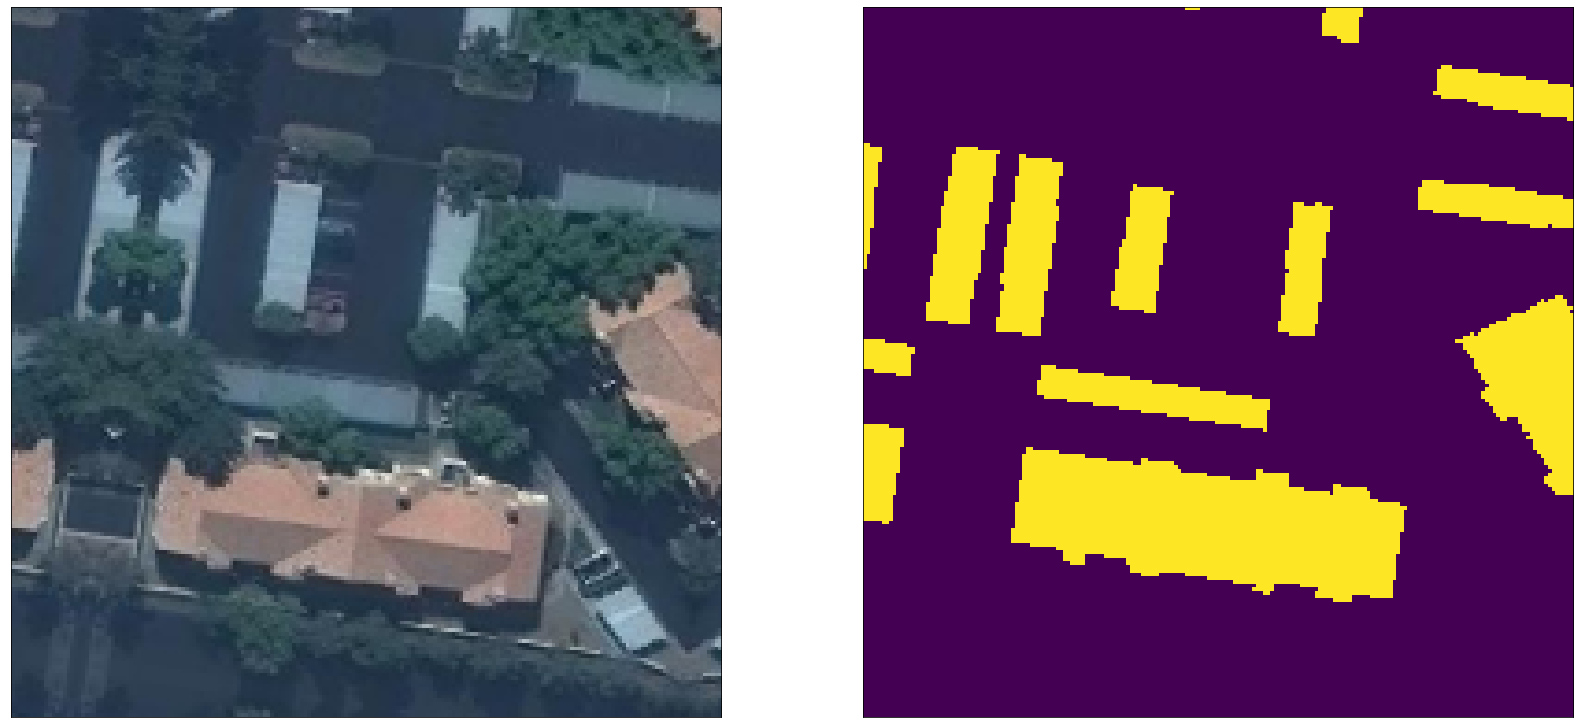

In [4]:
from helper_functions import plot_single_image, plot_multiple_images

for i,j in train_dataset:
    # print(len(i))
    # print(i)
    # for x in i:
        # print(np.array(x, dtype="int32"))
    # var_guay = i
    print(i.shape)
    print(j.shape)
    plot_multiple_images([np.array(i[0], dtype="uint8"), np.array(j[0], dtype="uint8")])
    break

### Resnet50 que usabamos anteriormente. Pasa de esta celda

In [8]:
def create_model(num_classes, dropout=False):

  # Función para crear cada uno de los bloques de convolución transpuesta, esto es, la operación contraria a la convolución
  # que trata de reconstruir una imagen. En mi caso lo he diseñado haciendo un 'espejo' de los bloques convolucionales.
  def decoder_block(input, skip_connection, num_filters, dropout=0):
      x = Conv2DTranspose(num_filters, 2, strides=2, padding="same", dtype="float32")(input)
      x = Concatenate()([x, skip_connection])

      x = Conv2D(num_filters, 3, padding="same", dtype="float32")(x)
      x = BatchNormalization(dtype="float32")(x)
      x = Activation("relu")(x)

      x = Conv2D(num_filters, 3, padding="same", dtype="float32")(x)
      x = BatchNormalization(dtype="float32")(x)
      x = Activation("relu")(x)

      if dropout:
        x = Dropout(dropout)(x)

      return x

  # Capa de entrada
  inputs = Input(input_shape)

  # Transfer Learning con Modelo ResNet entrenado sobre ImageNet
  residual = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
  
  # Descongelamos las cuatro últimas capas del modelo preentrenado para modificar sus pesos con nuestros datos,
  # de esta forma lo adaptamos mínimamente a nuestro problema
  residual.trainable = False
  residual.layers[-4].trainable = True

  # Outputs del encoder para conexiones residuales
  s1 = residual.get_layer(index=0).output
  s2 = residual.get_layer("conv1_relu").output
  s3 = residual.get_layer("conv2_block3_out").output
  s4 = residual.get_layer("conv3_block4_out").output

  # Puente
  b1 = residual.get_layer("conv4_block6_out").output

  # Decoder
  d1 = decoder_block(b1, s4, 512, 0.4 if dropout else None)
  d2 = decoder_block(d1, s3, 256, 0.3 if dropout else None)
  d3 = decoder_block(d2, s2, 128, 0.3 if dropout else None)
  d4 = decoder_block(d3, s1, 64, 0.2 if dropout else None)

  # Salida de la red
  outputs = Conv2D(num_classes, 3, padding="same", activation="softmax", dtype="float32")(d4)

  model = Model(inputs, outputs)
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy") 

  return model

### Celda de abajo para utilizar resnet en vez de satellite unet

In [ ]:
model = create_model(2, dropout=True)

### Satellite unet

In [4]:
model = satellite_unet(input_shape=input_shape)
model.compile(
  optimizer="adam", 
  loss="binary_crossentropy",
  metrics=[MeanIoU(num_classes=2, name="mean_iou")]
) 

### Cargar el modelo si ya se ha empezado a entrenar

In [9]:
model = load_model("personal/checkpoint/guay-0.391.h5")

### ENTRENAMOS AQUI

In [6]:
callbacks = [
             ModelCheckpoint(
                 'personal/checkpoint/guay-{val_mean_iou}.h5',
                 monitor='val_mean_iou',
                 save_best_only=False),
             EarlyStopping(monitor="val_mean_iou", patience=3)
]

STEPS = 25000
VALIDATION_STEPS = 5000

history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch = STEPS,
    batch_size=batch_size,
    validation_data = val_dataset,
    validation_steps = VALIDATION_STEPS,
    callbacks=callbacks
)

Epoch 1/5
25000/25000 [==============================] - 5736s 229ms/step - loss: 0.1080 - mean_iou: 0.3829 - val_loss: 0.1052 - val_mean_iou: 0.3910
Epoch 2/5
25000/25000 [==============================] - 5549s 222ms/step - loss: 0.1057 - mean_iou: 0.3829 - val_loss: 0.1021 - val_mean_iou: 0.3909
Epoch 3/5
25000/25000 [==============================] - 5625s 225ms/step - loss: 0.1039 - mean_iou: 0.3829 - val_loss: 0.1037 - val_mean_iou: 0.3908
Epoch 4/5
25000/25000 [==============================] - 5703s 228ms/step - loss: 0.1021 - mean_iou: 0.3828 - val_loss: 0.0997 - val_mean_iou: 0.3909
Epoch 5/5
25000/25000 [==============================] - 5789s 232ms/step - loss: 0.1006 - mean_iou: 0.3829 - val_loss: 0.0986 - val_mean_iou: 0.3910


### Evaluamos el modelo con nuestro dataset de test

In [10]:
results = model.evaluate(test_dataset)
results

363/363 [==============================] - 16s 43ms/step - loss: 0.1446 - mean_iou: 0.3775


[0.14459796249866486, 0.3775426745414734]

### Guardar el modelo para utilizarlo en el servidor

In [21]:
tfjs.converters.save_keras_model(model, "personal/server_model")

### Cargar el modelo para hacer predicciones. Cambiar la ruta con el archivo correspondiente

In [4]:
model = load_model("personal/checkpoint/guay-0.39.h5")

In [16]:
model = load_model("personal/modelo_tfg.h5")

### Cargar imagenes de ejemplo

In [5]:
img = cv2.imread("personal/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (img_width,img_height))

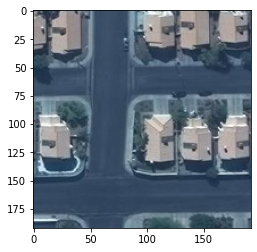

In [6]:
plt.imshow(img)

### Predecir

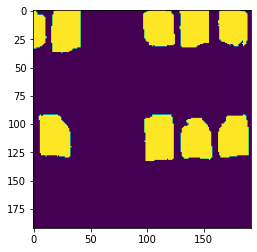

In [7]:
prediction = model.predict(np.expand_dims(img, 0))[0]
# Descomentar para el modelo con arquitectura ResNet
# prediction = np.argmax(prediction, axis=-1)
# prediction[prediction == 0] = 255
# prediction[prediction == 1] = 0
prediction = np.rint(prediction)
plt.imshow(prediction)

In [8]:
prediction = np.uint8(prediction)
prediction = cv2.blur(prediction, (3,3))
contours, hierarchy = cv2.findContours(prediction,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

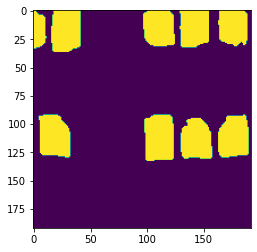

In [9]:
plt.imshow(prediction)

### Experimentos para detectar los elementos con cuadrados

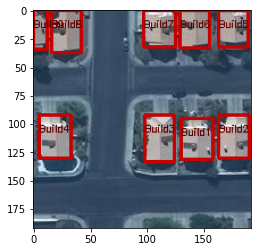

In [10]:
idx = 1
color = [tuple(np.random.choice(range(256), size=3)) for x in range(len(contours))]
for cnt in contours:
  x,y,w,h = cv2.boundingRect(cnt)
  if w > 10 and h > 10:
    roi=img[y:y+h,x:x+w]
    # cv2.rectangle(img,(x,y),(x+w,y+h),(int(color[idx][0]), int(color[idx][1]),int(color[idx][2])),2)
    cv2.rectangle(img,(x,y),(x+w,y+h),(200, 0, 0),2)
    # cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (int(color[idx][0]), int(color[idx][1]),int(color[idx][2])), 1)
    cv2.putText(img, "Build"+str(idx), (x, y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.28,(100, 0, 0), 1)
    idx += 1
plt.imshow(img)

### Codigo para predecir y detectar edificios con cuadrados en videos

In [16]:
cap = cv2.VideoCapture('personal/test_nzelanda2.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame = cv2.resize(frame, (img_width,img_height))
    prediction = model.predict(np.expand_dims(frame, 0))[0]
    # prediction = np.argmax(prediction, axis=-1)
    prediction = np.rint(prediction)
    prediction[prediction == 0] = 255
    prediction[prediction == 1] = 0
    prediction = np.uint8(prediction)
    prediction = cv2.blur(prediction, (3,3))
    contours, hierarchy = cv2.findContours(prediction,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    idx = 0
    color = [tuple(np.random.choice(range(256), size=3)) for x in range(len(contours))]
    for cnt in contours:
      x,y,w,h = cv2.boundingRect(cnt)
      if w > 10 and h > 10:
        roi=frame[y:y+h,x:x+w]
        # cv2.rectangle(img,(x,y),(x+w,y+h),(int(color[idx][0]), int(color[idx][1]),int(color[idx][2])),2)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 0, 200),2)
        # cv2.putText(img, "Build"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (int(color[idx][0]), int(color[idx][1]),int(color[idx][2])), 1)
        cv2.putText(frame, "Building"+str(idx), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(200, 0, 0), 1)
        idx += 1
    frame = cv2.resize(frame, (1080,720))
    prediction = cv2.cvtColor(prediction,cv2.COLOR_GRAY2RGB)
    prediction = cv2.resize(prediction, (1080,720))
    numpy_horizontal_concat = np.concatenate((frame, prediction), axis=1)

    cv2.imshow('frame', numpy_horizontal_concat)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()